# Apply Albumentations Perturbations Using NRTK

This notebook demonstrates how to use Albumentations perturbers in an NRTK context using a sample image from the [VisDrone](https://github.com/VisDrone/VisDrone-Dataset) dataset.

Documentation on the available perturbers and their parameters can be found on the [documentation for the Albumentations module](https://albumentations.ai/docs/examples/example-weather-transforms/). Note, Kitware maintains a [fork of albumentations](https://github.com/Kitware/nrtk-albumentations), specifically for integration with NRTK. As development continues by the original authors of Albumentations, on [AlbumentationsX](https://github.com/albumentations-team/AlbumentationsX), the functionality between the hosted documentation and our fork may diverge. 

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/nrtk/blob/main/docs/examples/albumentations_perturbers.ipynb)

## Set Up the Environment

**Note for Colab users**: After setting up the environment, you may need to "Restart Runtime" to resolve package version conflicts (see the [README](https://github.com/Kitware/nrtk/blob/main/docs/examples/README.md#run-the-notebooks-from-colab) for more info).

This notebook requires NRTK with the following extra: `albumentations`

- `albumentations` - Kitware's fork of Albumentations for weather and transformation perturbations

Note: We are suppressing warnings within this notebook to reduce visual clutter for demonstration purposes. If any issues arise while executing this notebook, we recommend that this cell is **not** executed so that any related warnings are shown. 

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
%pip install -qU pip
print("Installing nrtk with required extras...")
%pip install -q "nrtk[albumentations,headless]"
print("Installing notebook-specific packages...")
%pip install -q matplotlib
print("Done!")

from nrtk.utils._extras import print_extras_status  # noqa: E402 - intentionally after %pip install

print_extras_status()

Note: you may need to restart the kernel to use updated packages.
Installing nrtk with required extras...


Note: you may need to restart the kernel to use updated packages.
Installing notebook-specific packages...


Note: you may need to restart the kernel to use updated packages.
Done!


Detected status of NRTK extras and their dependencies:



[albumentations]
  - nrtk-albumentations       ✓ 2.2.1

[diffusion]
  - torch                     ✗ missing
  - diffusers                 ✗ missing
  - accelerate                ✗ missing
  - Pillow                    ✓ 12.1.1
  - transformers              ✗ missing
  - protobuf                  ✗ missing

[graphics]
  - opencv-python             ✗ missing

[headless]
  - opencv-python-headless    ✓ 4.13.0.92

[maite]
  - maite                     ✗ missing

[pillow]
  - Pillow                    ✓ 12.1.1

[pybsm]
  - pybsm                     ✗ missing

[skimage]
  - scikit-image              ✗ missing

[tools]
  - kwcoco                    ✗ missing
  - Pillow                    ✓ 12.1.1
  - click                     ✓ 8.3.1
  - fastapi                   ✗ missing
  - uvicorn                   ✗ missing
  - pydantic                  ✓ 2.12.5
  - pydantic-settings         ✗ missing
  - python-json-logger        ✗ missing

[waterdroplet]
  - scipy                     ✓ 1.17.0
  - numba

    https://nrtk.readthedocs.io/en/stable/



In [3]:
%matplotlib inline
%config InlineBackend.figure_format = "jpeg"  # Use JPEG format for inline visualizations
import os
import urllib.request
from typing import TYPE_CHECKING

import numpy as np
from matplotlib import patches
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from PIL import Image
from smqtk_image_io.bbox import AxisAlignedBoundingBox

from nrtk.impls.perturb_image import (
    AlbumentationsPerturber,  # requires `albumentations` and `headless` (or `graphics`) extra
)

## Select Initial Image

We'll carry out perturbations on a single image from VisDrone.

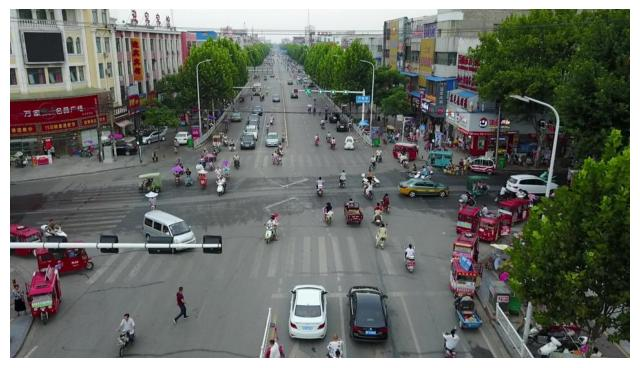

In [4]:
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

url = "https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download"

img_path = os.path.join(data_dir, "visdrone_img.jpg")
if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve(url, img_path)  # noqa: S310

img = np.asarray(Image.open(img_path))

plt.figure(figsize=(8, 8))
plt.axis("off")
_ = plt.imshow(img)

We'll also define a helper functions for displaying our perturbations.

In [5]:
def display_pert(img: np.ndarray, descriptor: str = "", bbox: AxisAlignedBoundingBox | None = None) -> None:
    """Display perturbation."""
    _, axs = plt.subplots(figsize=(8, 8))
    if TYPE_CHECKING:
        assert isinstance(axs, Axes)
    if bbox:
        rect = patches.Rectangle(
            (bbox.min_vertex[0], bbox.min_vertex[1]),
            bbox.max_vertex[0] - bbox.min_vertex[0],
            bbox.max_vertex[1] - bbox.min_vertex[1],
            linewidth=2,
            edgecolor="r",
            facecolor="none",
        )
        axs.add_patch(rect)
    axs.set_title(descriptor)
    axs.imshow(img)

    axs.axis("off")

## RandomRain

This transform simulates rainfall by overlaying semi-transparent streaks onto the image, creating a realistic rain effect. It can be used to augment datasets for computer vision tasks that need to perform well in rainy conditions.

**Usage Notes:**

The `AlbumentationsPerturber` accepts the following arguments:
- `perturber`: Name of the class extending `BasicTransform` (e.g. "RandomRain")
- `parameters`: Dictionary of parameters for the chosen perturber's constructor
- `seed`: Optional integer to set a seed for reproducibility

Note that `parameters["p"]` represents the probability of the perturbation occurring (default: 0.5). To ensure the transform always applies, set `"p": 1.0` in the parameters.

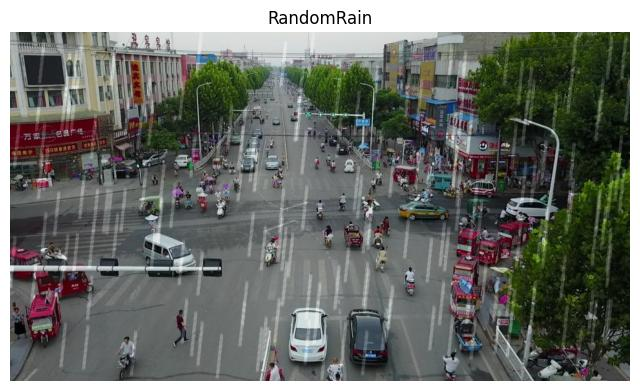

In [6]:
parameters = {"brightness_coefficient": 0.9, "drop_width": 1, "blur_value": 5, "p": 1.0}
perturber = AlbumentationsPerturber(perturber="RandomRain", parameters=parameters, seed=7)
img_out, _ = perturber(image=img)
display_pert(img_out, "RandomRain")

## RandomFog

This transform simulates fog by adding semi-transparent overlays that mimic its visual characteristics of fog. The fog intensity and distribution can be controlled to create a range of fog-like conditions.

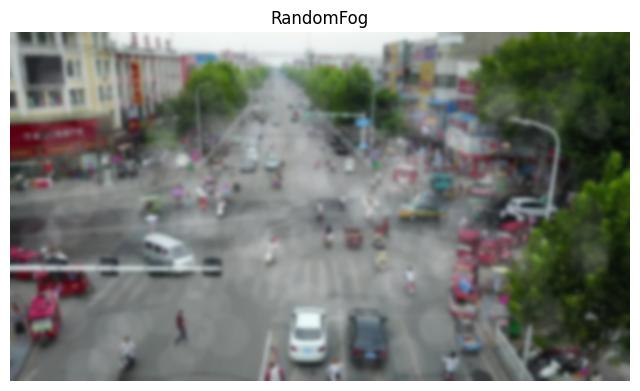

In [7]:
parameters = {"fog_coef_range": (0.7, 0.8), "alpha_coef": 0.1, "p": 1.0}
perturber = AlbumentationsPerturber(perturber="RandomFog", parameters=parameters, seed=7)
img_out, _ = perturber(image=img)
display_pert(img_out, "RandomFog")

## RandomSnow

This transform simulates snowfall by bleaching out some pixel values and adjusting brightness, creating a realistic snow effect on the image.

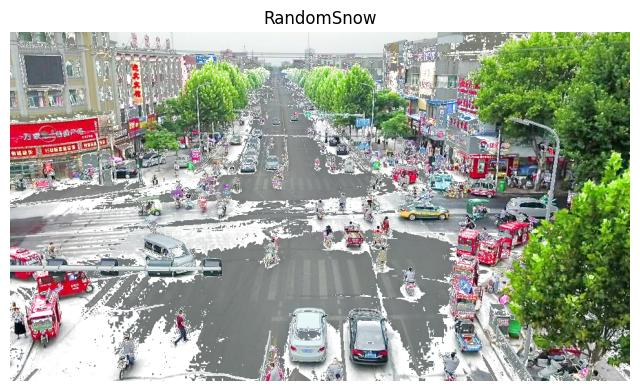

In [8]:
parameters = {"snow_point_range": (0.2, 0.4), "brightness_coeff": 2.5, "p": 1.0}

perturber = AlbumentationsPerturber(perturber="RandomSnow", parameters=parameters, seed=7)
img_out, _ = perturber(image=img)
display_pert(img_out, "RandomSnow")

## RandomSunFlare

This transform simulates a sun flare effect by overlaying multiple semi-transparent circles of varying sizes and intensities along a line originating from a "sun" point.

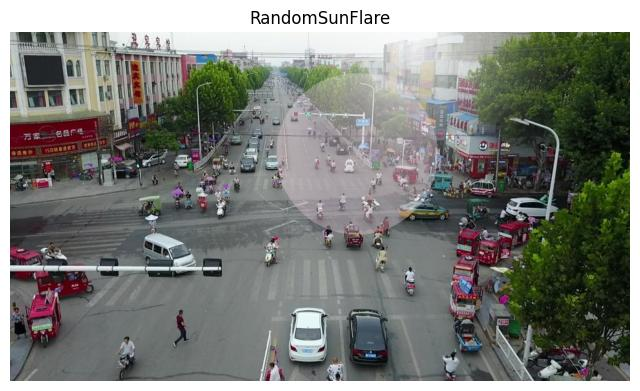

In [9]:
parameters = {"flare_roi": (0, 0, 1, 0.5), "angle_range": (0.25, 0.75), "p": 1.0}

perturber = AlbumentationsPerturber(perturber="RandomSunFlare", parameters=parameters, seed=7)
img_out, _ = perturber(image=img)
display_pert(img_out, "RandomSunFlare")

## Bounding Boxes

The following example performs a `HorizontalFlip` to demonstrate how a transform updates bounding boxes.

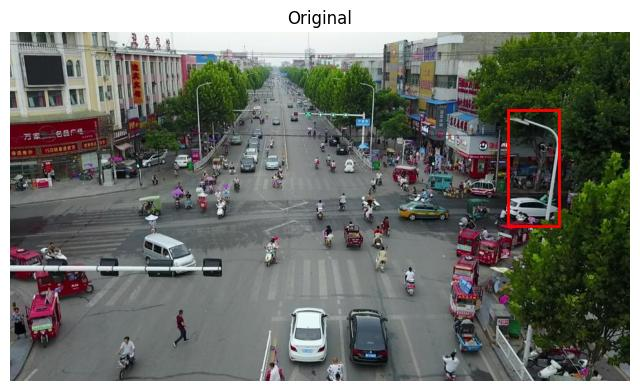

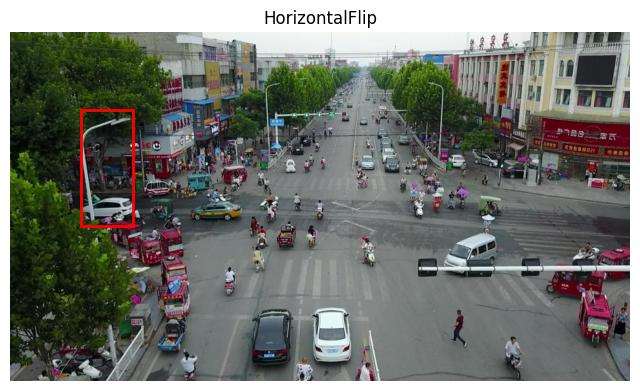

In [10]:
conf_dict = {}
conf_dict["label"] = 1.0
bboxes = [(AxisAlignedBoundingBox((770, 120), (850, 300)), conf_dict)]
perturber = AlbumentationsPerturber(perturber="HorizontalFlip", parameters={"p": 1})
img_out, output_bboxes = perturber(image=img, boxes=bboxes)
display_pert(img, "Original", bbox=bboxes[0][0])
if output_bboxes:
    op_bboxes = list(output_bboxes)[0][0]
    display_pert(img_out, "HorizontalFlip", bbox=op_bboxes)